# 2値分類

<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>
<script type="text/x-mathjax-config">
 MathJax.Hub.Config({
 tex2jax: {
 inlineMath: [['$', '$'] ],
 displayMath: [ ['$$','$$'], ["\\[","\\]"] ]
 }
 });
</script>

## ロジスティック回帰

### シグモイド関数
$$ p(x) = \frac{1}{1 + e^{-x}} $$

この式のxには線形回帰の出力が入るイメージである.  
つまり、$p(x) = \frac{1}{1 + e^{-(θ_0 + θ_1X)}} $という感じであり、$p(x)$は$θ$の式と考えることが可能である.  

### Log Loss(損失関数)
$$
\begin{equation}
    Cost(p(x_i), y_i) =
  \left\{ 
  \begin{alignedat}{2}  
    -log(p(x_i))\hspace{20pt}if:y_i=1 \\   
    -log(1 - p(x_i)) \hspace{10pt}if:y_i=0
  \end{alignedat} 
  \right.
\end{equation}$$

この式は正解ラベルが1の時と0の時で場合分けされている.  
これを一式で表すと以下のようになる.
$$ Cost(p(x_i), y_i) = -(y_ilog(p(x_i)) + (1 - y_i)log(1 - p(x_i))) $$

この式の平均がロジスティック回帰の目的関数となり、最急降下法で最適解を求める.   
$$ L(θ) = -\frac{1}{m}\sum_{i = 1}^m y_ilog(p(x_i)) + (1 - y_i)log(1 - p(x_i))  $$
$$ p(x_i) = \frac{1}{1 + e^{-(θ_0 + θ_1X_i)}} $$

この式が最小となる$θ$を求める.  
$θ_0 := θ_0 - α\frac{\partial}{\partial θ_0}L(θ_0, θ_1) $  
$θ_1 := θ_1 - α\frac{\partial}{\partial θ_1}L(θ_0, θ_1) $  

上記の偏微分は以下のようになる.  
$\frac{\partial}{\partial θ_0}L(θ_0, θ_1) = \frac{1}{m}\sum_{i = 1}^m(p(x_i) - y_i)$  
$\frac{\partial}{\partial θ_1}L(θ_0, θ_1) = \frac{1}{m}\sum_{i = 1}^m(p(x_i) - y_i)x_i$


In [11]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# 前処理

# 文字列の半角スペース削除
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)

print(df.shape)
df.head()
     

(29170, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,0


In [5]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']

In [6]:
# カテゴリ変数
X.describe(exclude='number').T

,count,unique,top,freq
workclass,29170,9,Private,20135
education,29170,16,HS-grad,9702
marital-status,29170,7,Married-civ-spouse,13368
occupation,29170,15,Exec-managerial,3735
relationship,29170,6,Husband,11861
race,29170,5,White,25621
gender,29170,2,Male,19488


In [7]:
# one-hot encoding
X = pd.concat([X, pd.get_dummies(X['workclass'], prefix='workclass', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['education'], prefix='education', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['marital-status'], prefix='marital-status', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['occupation'], prefix='occupation', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['relationship'], prefix='relationship', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix='race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['gender'], prefix='gender', drop_first=True)], axis=1)
X = X.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender'], axis=1)
print(X.shape)


(29170, 59)


In [13]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male
0,39,77516,13,2174,0,40,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,38,215646,9,0,0,40,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,37,284582,14,0,0,40,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [8]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (23336, 59)  y_trainの形状： (23336,)  X_testの形状： (5834, 59)  y_testの形状： (5834,)


In [9]:
# 学習データとテストデータのラベル件数内訳
print(y_train.value_counts())
print(y_test.value_counts())

0    17599
1     5737
Name: income, dtype: int64
0    4400
1    1434
Name: income, dtype: int64


In [10]:
# 特徴量の標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 変換器の作成
num_cols =  X.columns[0:6] # 数値型の特徴量を取得
scaler.fit(X_train[num_cols]) # 学習データでの標準化パラメータの計算
X_train[num_cols] = scaler.transform(X_train[num_cols]) # 学習データの変換
X_test[num_cols] = scaler.transform(X_test[num_cols]) # テストデータの変換

display(X_train.iloc[:2]) # 標準化された学習データの特徴量

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male
14415,-0.414934,2.618674,-0.482654,0.286912,-0.220058,0.780378,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
24513,-1.286423,-0.861896,-0.066531,-0.149041,-0.220058,-2.288775,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [12]:
# ロジスティック回帰モデル
model = LogisticRegression(max_iter=100, multi_class = 'ovr', solver='liblinear', C=0.1, penalty='l1', random_state=0)
model.fit(X_train, y_train)
model.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### ロジスティック回帰の主要なハイパーパラメータについて
- C : 正則化項の強さを指定する. λやαでよく与えられるが、これはそれらの逆数である.つまり小さいほど強い.  
- penalty : l1、l2(正則化項)、elasticnet(l1とl2の両方)、None
- max_iter : 勾配を更新する回数(最急降下法)
- solver : 最適化問題で使用するアルゴリズム.
    - ‘lbfgs’ - [‘l2’, None]
    - ‘liblinear’ - [‘l1’, ‘l2’] (小さなデータセット向きで、他クラス分類の時はovrを使用)
    - ‘newton-cg’ - [‘l2’, None] (n_samples >> n_featuresで、ワンホットエンコードされたカテゴリカルな特徴量やまれなカテゴリを持つ場合に良い. また二値分類か他クラス分類(ovr)に制限される)
    - ‘newton-cholesky’ - [‘l2’, None]
    - ‘sag’ - [‘l2’, None] (大規模なデータセット向き)
    - ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None] (大規模なデータセット向き)
- multi_class : auto, ovr, multinomial (autoはovrを使用する)
    - ovr : クラスの数だけ分類器を作り、各クラスの確率を出力し、一番確率の高いクラスを予測値とする.
    - multinomial : ソフトマックス関数を使用する

In [14]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

accuracy = 0.84
F1-score = 0.64


Text(45.722222222222214, 0.5, 'label')

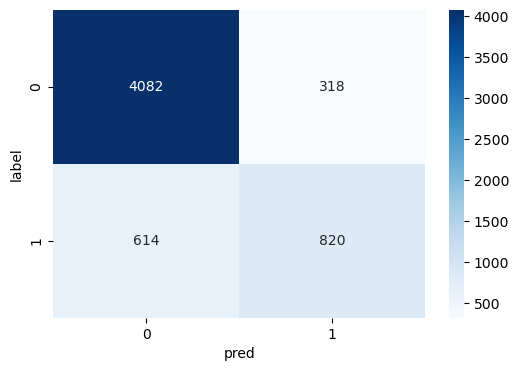

In [15]:
# 混同行列
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('label')

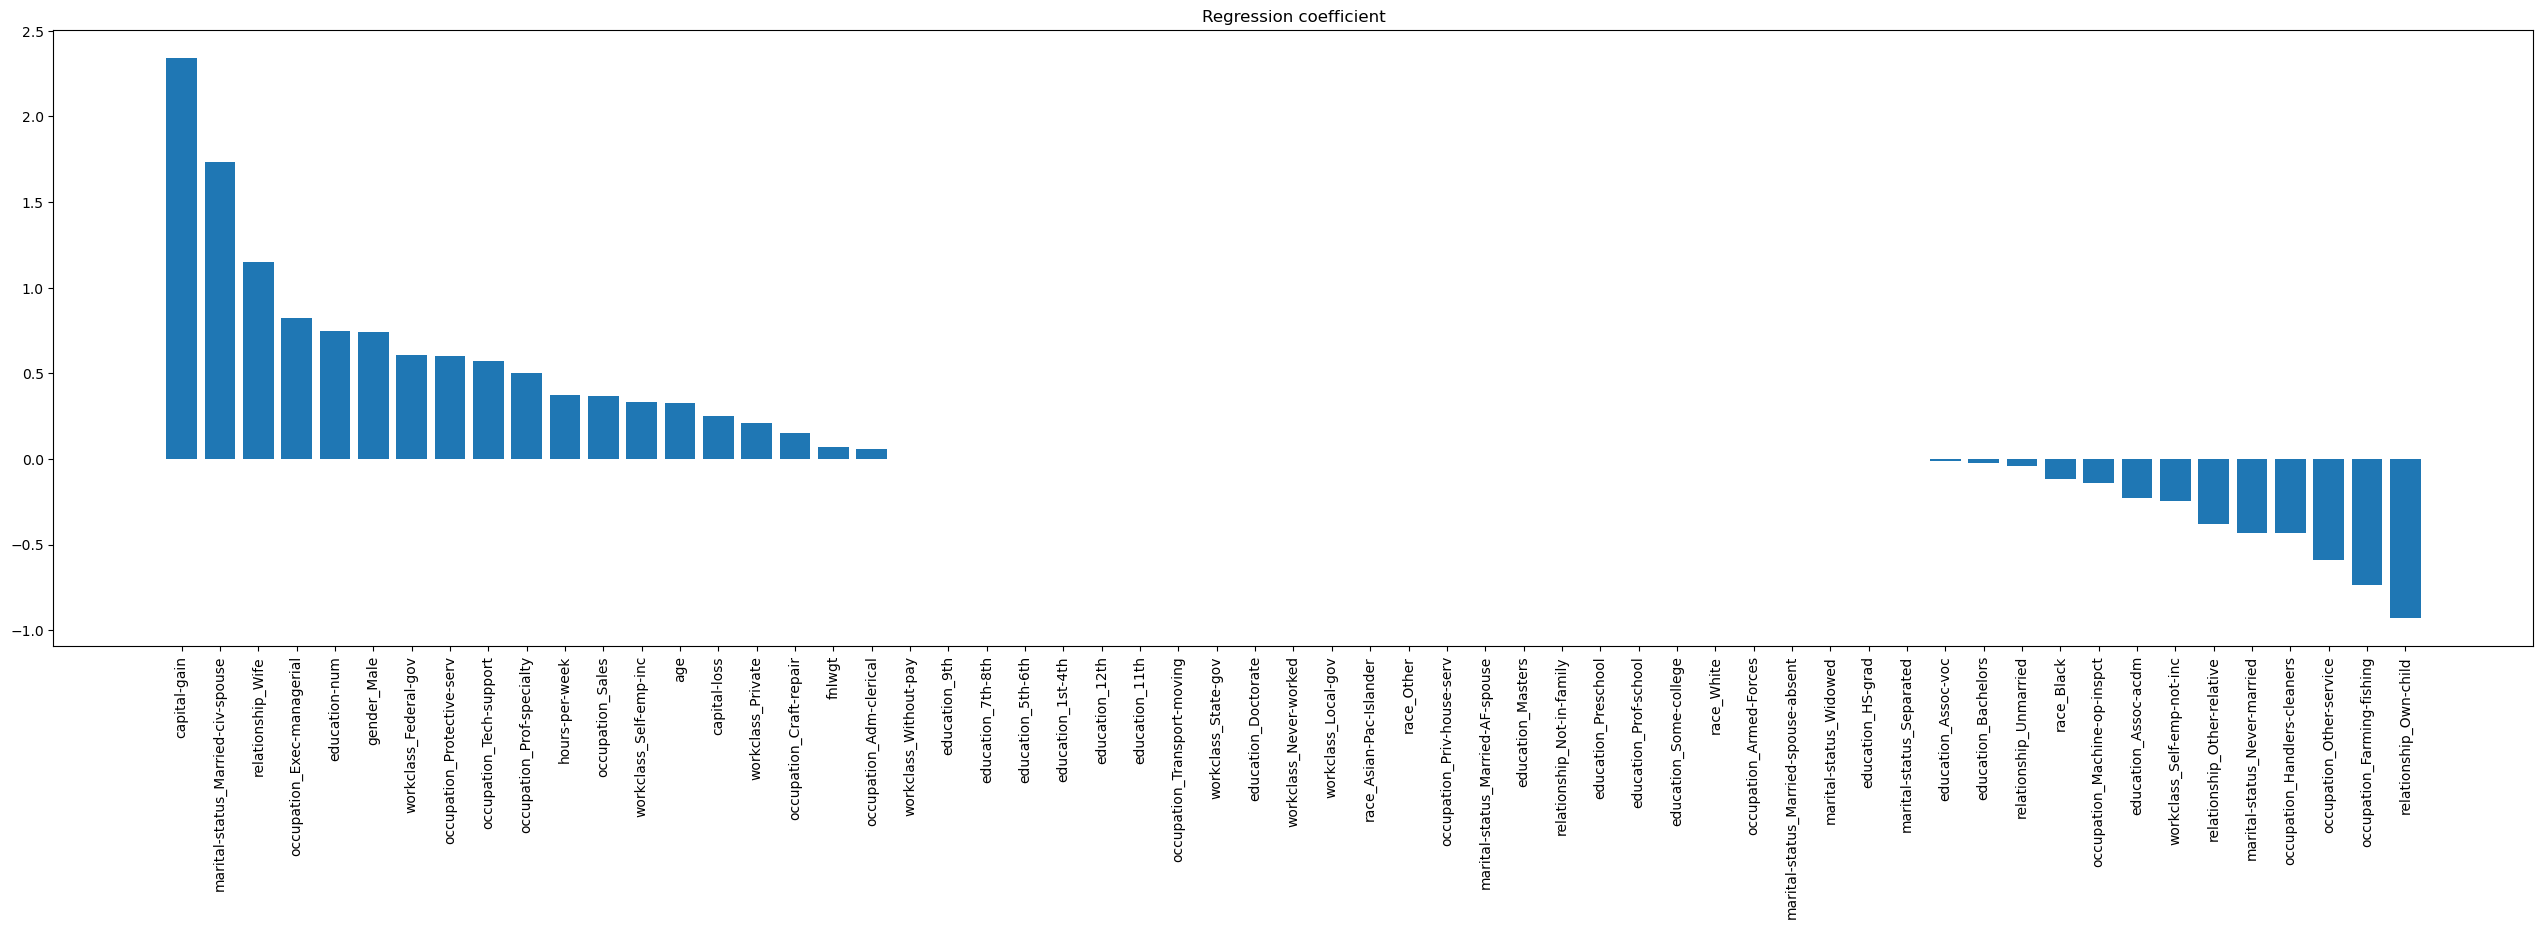

In [16]:
# 回帰係数の可視化
importances = model.coef_[0] # 回帰係数
indices = np.argsort(importances)[::-1] # 回帰係数を降順にソート

plt.figure(figsize=(32, 8)) #プロットのサイズ指定
plt.title('Regression coefficient') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加

plt.show() # プロットを表示

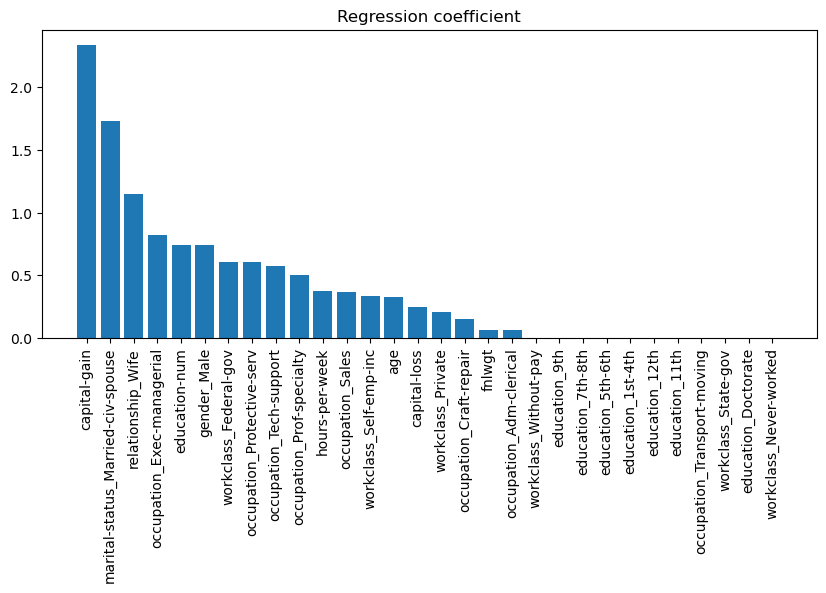

In [17]:
# 回帰係数（上位30件）の可視化
importances = model.coef_[0] # 回帰係数
indices = np.argsort(importances)[::-1][:30] # 回帰係数を降順にソート

plt.figure(figsize=(10, 4)) #プロットのサイズ指定
plt.title('Regression coefficient') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加

plt.show() # プロットを表示

### 各確率値に貢献した量をロジットを用いて特徴量ごとに見る

In [19]:
y_test_proba = model.predict_proba(X_test)
y_test_proba

array([[0.61193763, 0.38806237],
       [0.76941821, 0.23058179],
       [0.82273794, 0.17726206],
       ...,
       [0.00571831, 0.99428169],
       [0.98302486, 0.01697514],
       [0.97352591, 0.02647409]])

In [39]:
# 最後から3番目の確率値に着目
print(f'最後から3番目 : {y_test_proba[-3]}')
# ロジットを求める
logit = X_test.iloc[-3, :].values.reshape(1, -1) @ model.coef_[0].T + model.intercept_.item()
print(f'ロジット : {logit}')

最後から3番目 : [0.00571831 0.99428169]
ロジット : [5.15834652]


In [40]:
# ロジットを特徴量とモデル係数分解することで、各確率値はの導出を確認できる